**Задача:**

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

**Описание данных**

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

- `User Id` — уникальный идентификатор пользователя
- `Device` — категория устройства пользователя
- `Session start` — дата и время начала сессии
- `Session End` — дата и время окончания сессии
- `Channel` — идентификатор рекламного источника, из которого пришел пользователь
- `Region` - страна пользователя

Таблица orders_log_short (информация о заказах):

- `User Id` — уникальный id пользователя, который сделал заказ
- `Event Dt` — дата и время покупки
- `Revenue` — выручка

Таблица costs_short (информация о затратах на маркетинг):

- `Channel` — идентификатор рекламного источника
- `Dt` — дата
- `Costs` — затраты на этот рекламный источник в этот день

## Загрузка данных и изучение общей информации

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [7]:
visits = pd.read_csv(r'C:\Users\564\Downloads\visits_info_short.csv')
orders = pd.read_csv(r'C:\Users\564\Downloads\orders_info_short.csv')
costs = pd.read_csv(r'C:\Users\564\Downloads\costs_info_short.csv')

In [8]:
visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [9]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [10]:
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [11]:
# Преобразуем тип данных в столбцах с датами в datetime

visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [12]:
# Проверка на наличие явных дубликатов

print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


Приведем названия столбцов к змеиному регистру

In [13]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

**Вывод:**

Пропусков и дубликатов в таблицах не обнаружено, типы данных корректны

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

In [14]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [15]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [16]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [17]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [18]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [19]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [20]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [21]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

In [22]:
# Создание пользовательских профилей
profiles = get_profiles(visits, orders, costs)

display(profiles.head())
print('Минимальная дата привлечения:', profiles['dt'].min(), 
      '\nМаксимальная дата привлечения:', profiles['dt'].max())

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Минимальная дата привлечения: 2019-05-01 
Максимальная дата привлечения: 2019-10-27


Даты соответствуют заявленым, значит данные собраны верно

### Посмотрим, из каких стран приходят посетители и какие страны дают больше всего платящих пользователей

In [23]:
region_visitors = (profiles.query('payer == 0')
.groupby('region').agg({'user_id': 'count'})
.rename(columns={'user_id': 'visitors'}))

region_payers = (profiles.query('payer == 1')
.groupby('region').agg({'user_id': 'count'})
.rename(columns={'user_id': 'payers'}))

region_visitors_payers = region_visitors.merge(region_payers, on='region')
region_visitors_payers['conversion'] = region_visitors_payers['payers'] / region_visitors_payers['visitors']
region_visitors_payers.sort_values(by='conversion', ascending=False)
region_visitors_payers['conversion'] = ((region_visitors_payers['conversion']*100)
.round(2).astype(str) + '%')
region_visitors_payers

,visitors,payers,conversion
region,,,
France,16787,663,3.95%
Germany,14365,616,4.29%
UK,16875,700,4.15%
United States,93100,6902,7.41%


### Посмотрим, какими устройствами пользуются посетители и с каких устройств чаще всего заходят платящие пользователи

In [24]:
device_visitors = (profiles.query('payer == 0')
.groupby('device').agg({'user_id': 'count'})
.rename(columns={'user_id': 'visitors'}))

device_payers = (profiles.query('payer == 1')
.groupby('device').agg({'user_id': 'count'})
.rename(columns={'user_id': 'payers'}))

device_visitors_payers = device_visitors.merge(device_payers, on='device')
device_visitors_payers['conversion'] = device_visitors_payers['payers'] / device_visitors_payers['visitors']
device_visitors_payers.sort_values(by='conversion', ascending=False)
device_visitors_payers['conversion'] = ((device_visitors_payers['conversion']*100)
.round(2).astype(str) + '%')
device_visitors_payers

,visitors,payers,conversion
device,,,
Android,32982,2050,6.22%
Mac,28130,1912,6.8%
PC,28918,1537,5.32%
iPhone,51097,3382,6.62%


### Посмотрим, по каким рекламным каналам шло привлечение пользователей и какие каналы приносят больше всего платящих пользователей

In [25]:
channels_visitors = (profiles.query('payer == 0')
.groupby('channel').agg({'user_id': 'count'})
.rename(columns={'user_id': 'visitors'}))

channels_payers = (profiles.query('payer == 1')
.groupby('channel').agg({'user_id': 'count'})
.rename(columns={'user_id': 'payers'}))

channels_visitors_payers = channels_visitors.merge(channels_payers, on='channel')
channels_visitors_payers['conversion'] = channels_visitors_payers['payers'] / channels_visitors_payers['visitors']
channels_visitors_payers.sort_values(by='conversion', ascending=False)
channels_visitors_payers['conversion'] = ((channels_visitors_payers['conversion']*100)
.round(2).astype(str) + '%')
channels_visitors_payers

,visitors,payers,conversion
channel,,,
AdNonSense,3440,440,12.79%
FaceBoom,25587,3557,13.9%
LeapBob,8291,262,3.16%
MediaTornado,4208,156,3.71%
OppleCreativeMedia,8372,233,2.78%
RocketSuperAds,4096,352,8.59%
TipTop,17683,1878,10.62%
WahooNetBanner,8100,453,5.59%
YRabbit,4147,165,3.98%


**Выводы:**

- PC заметно уступает остальным устройствам в конверсии поситителей в покупателей
- Очень низкая конверсия у organic поситителей

## Маркетинг

### Посмотрим, как траты распределены по источникам

In [26]:
costs_grouped = (costs.groupby('channel').agg({'costs': 'sum'})
.sort_values(by='costs', ascending=False))

display(costs_grouped)
print('Общая сумма расходов на маркетинг: {:.1f}'.format(costs['costs'].sum()))

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Общая сумма расходов на маркетинг: 105497.3


Визуализируем изменения метрик во времени

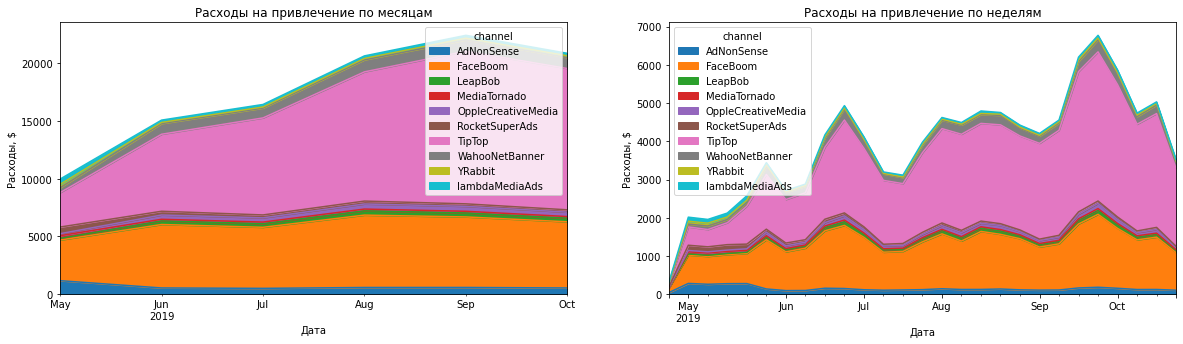

In [27]:
costs['Расходы на привлечение по месяцам'] = costs['dt'].astype('datetime64[M]')
costs['Расходы на привлечение по неделям'] = costs['dt'].astype('datetime64[W]')

columns = ['Расходы на привлечение по месяцам', 'Расходы на привлечение по неделям']

plt.subplots(figsize = (20, 5))

for i, col in enumerate(columns):
    costs.pivot_table(index = col, columns = 'channel', values = 'costs', aggfunc = 'sum').plot.area(ax = plt.subplot(1, 2, i + 1))
    plt.title(col)
    plt.xlabel('Дата')
    plt.ylabel('Расходы, $')
 
plt.show()

### Посмотрим, сколько в среднем стоило привлечение одного пользователя из каждого источника

In [29]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders,
datetime(2019, 10, 28).date(), 1, dimensions=['channel'])

roi.drop(columns=['cohort_size', 0]).sort_values(by='cac', ascending=False).round(2)

,cac
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


**Вывод:**

Больше всего денег вкладывалось в каналы с самой высокой стоимостью привлечения клиента (TipTop и FaceBoom)

## Оценим окупаемость рекламы для привлечения пользователей

### Проанализируем общую окупаемость рекламы

In [30]:
horizon_days = 14
observation_date = datetime(2019, 11, 1).date()

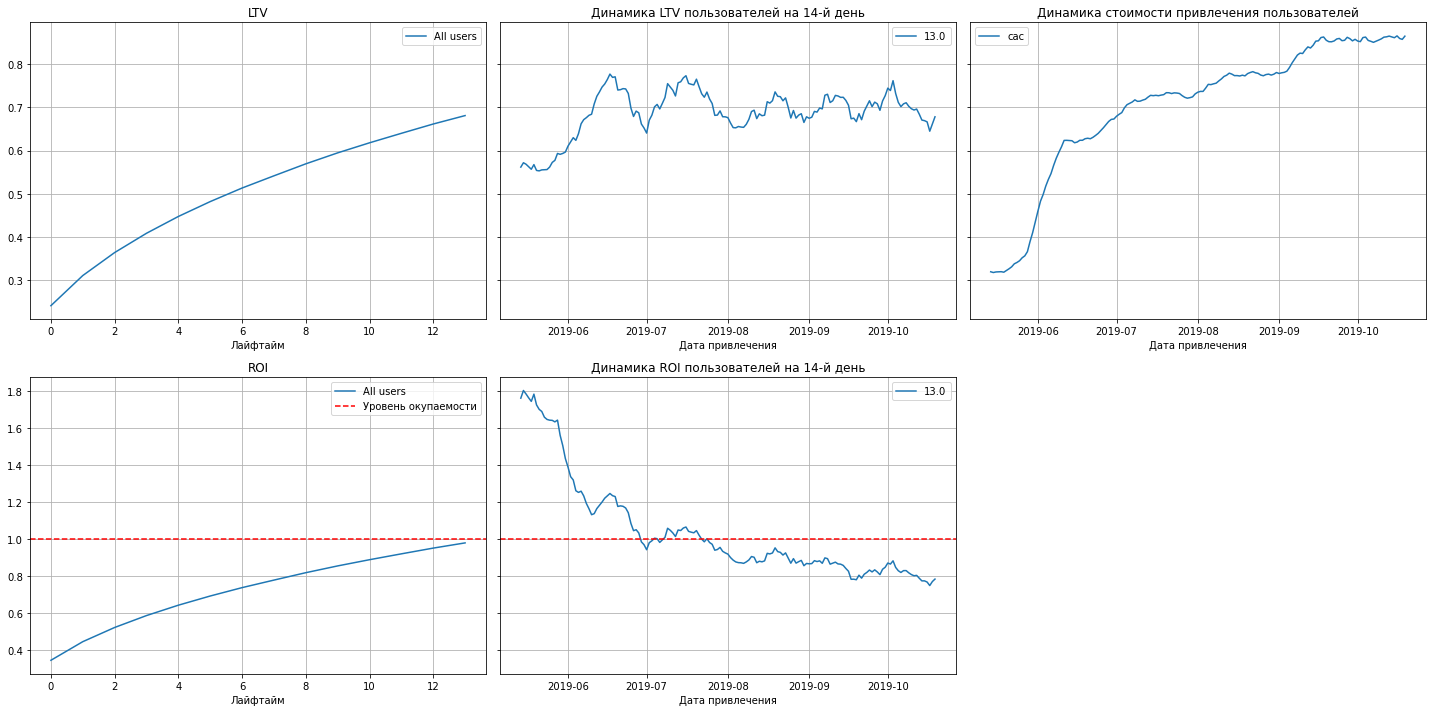

In [31]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders,
datetime(2019, 11, 1).date(), 14)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

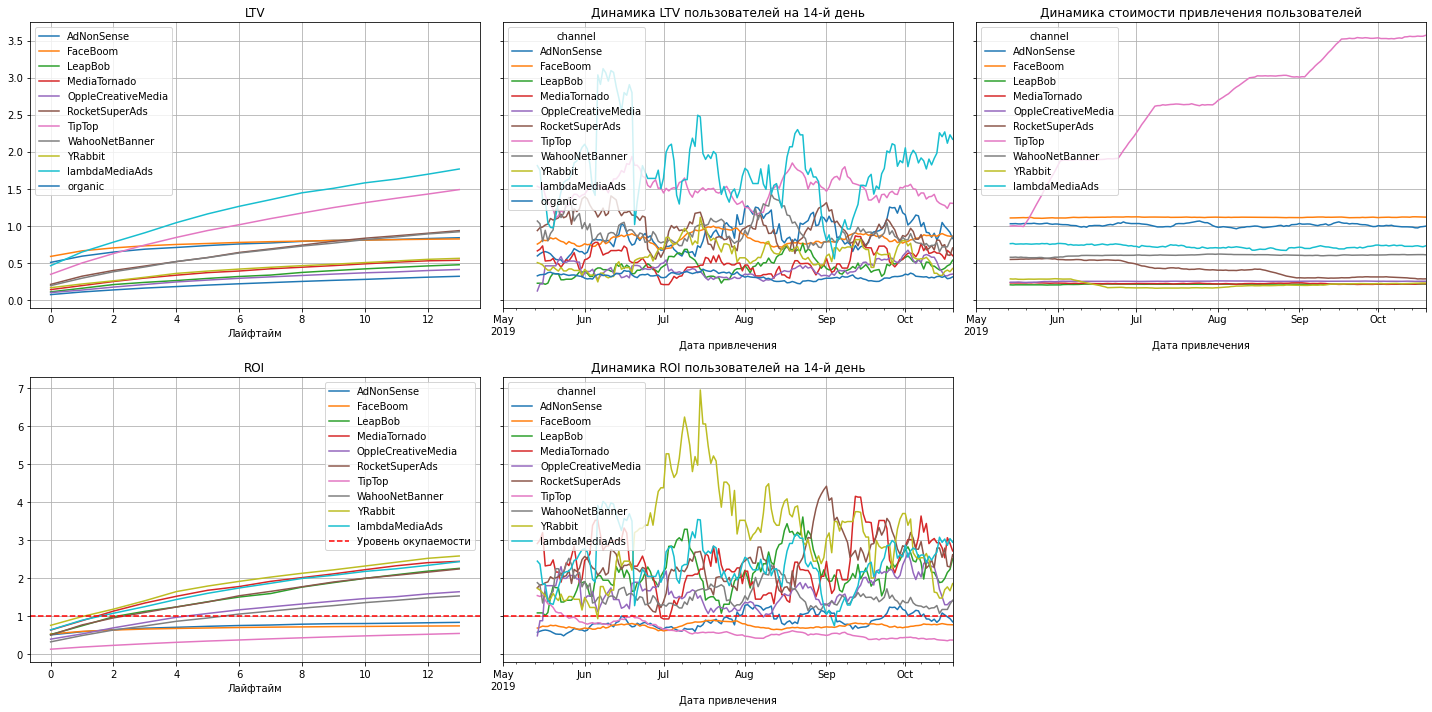

In [32]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders,
datetime(2019, 11, 1).date(), 14, dimensions=['channel'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

### Проанализируем окупаемость рекламы с разбивкой по странам

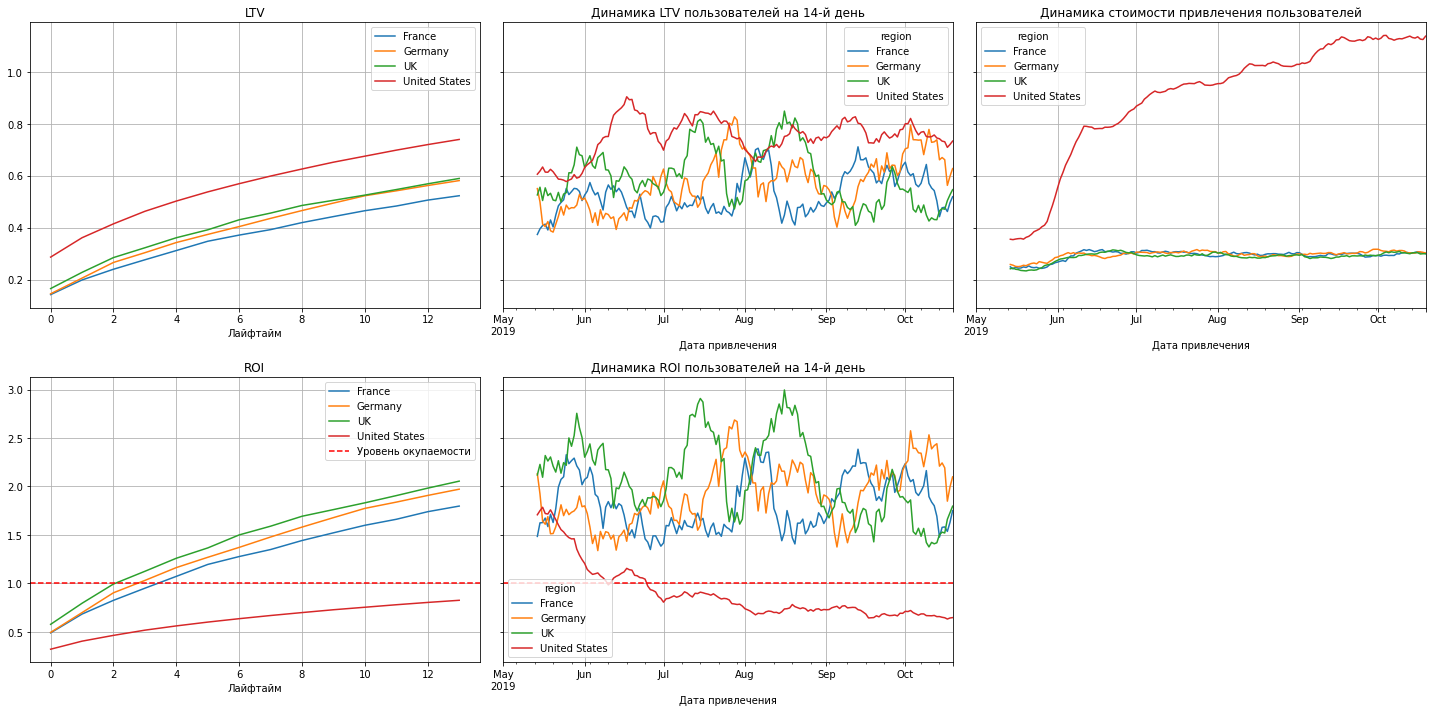

In [33]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders,
datetime(2019, 11, 1).date(), 14, dimensions=['region'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

**Выводы:**

- В конце мая начался рост стоимости привлечения пользователей и падение ROI, LTV при этом оставалось стабильным и даже немного выросло
- Практически весь рост стоимости привлечения пользователей пришелся на американский регион, что сильно сказалось на окупаемости инвестиций
- Привлечение пользователей через рекламные каналы TipTop, FaceBoom и AdNonSence оказалось убыточным

### Построим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам

Посмотрим на конверсию и удержание с разбивкой по устройствам

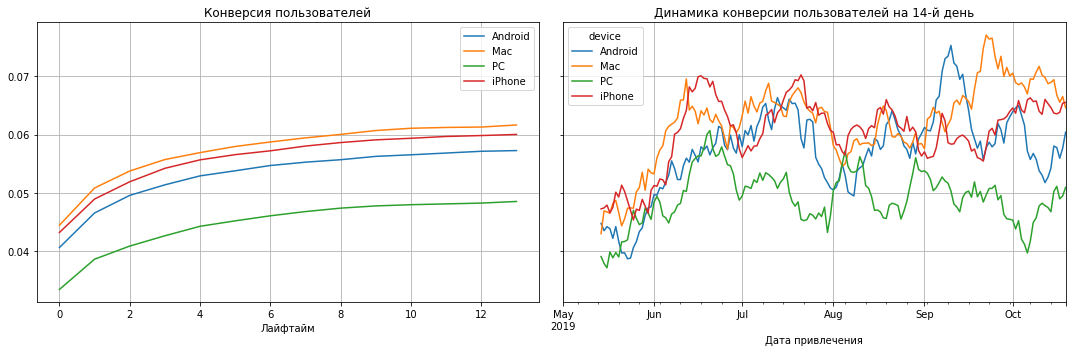

In [34]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

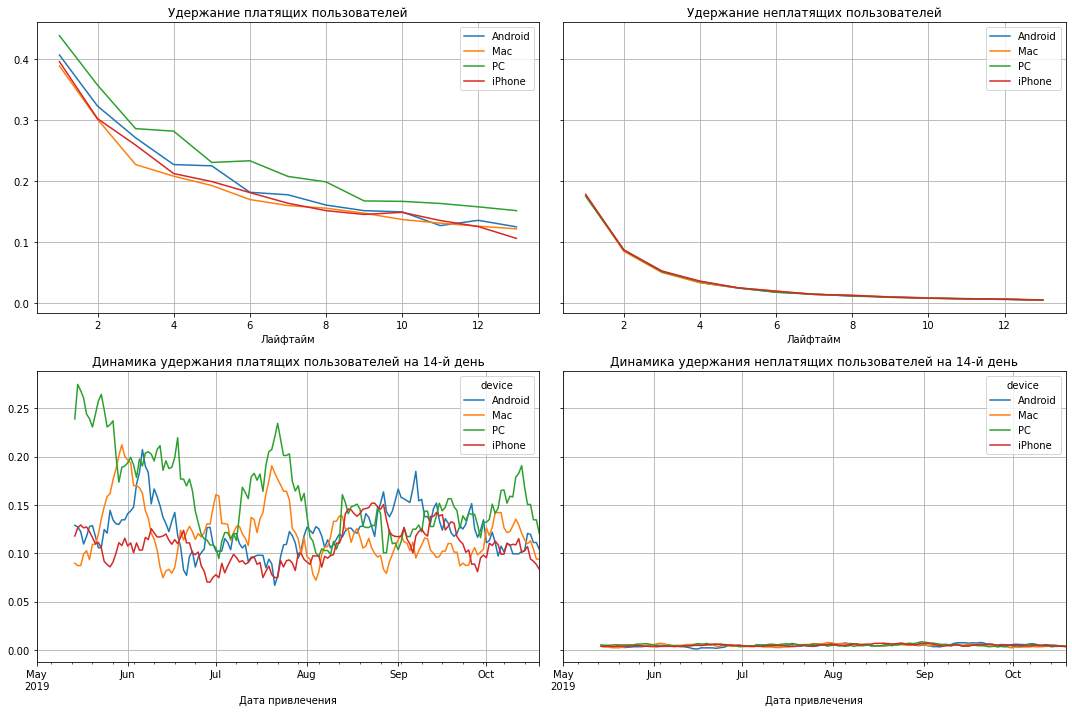

In [35]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device'])

plot_retention(retention_grouped, retention_history, horizon_days, window=14)

Посмотрим на конверсию и удержание с разбивкой по странам

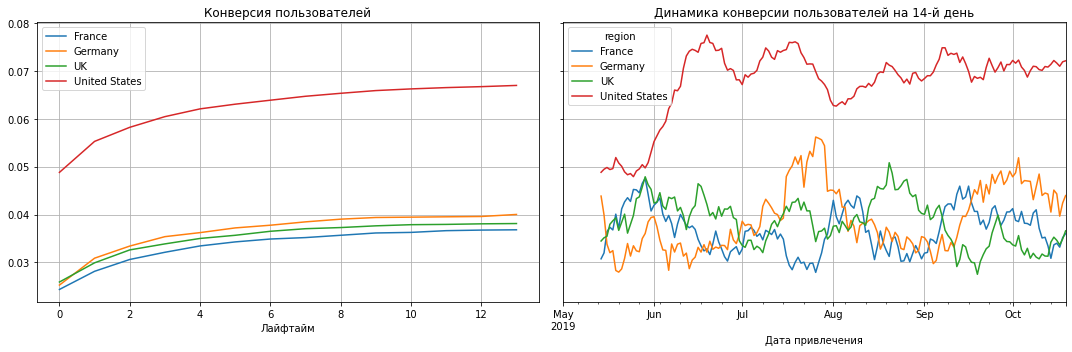

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

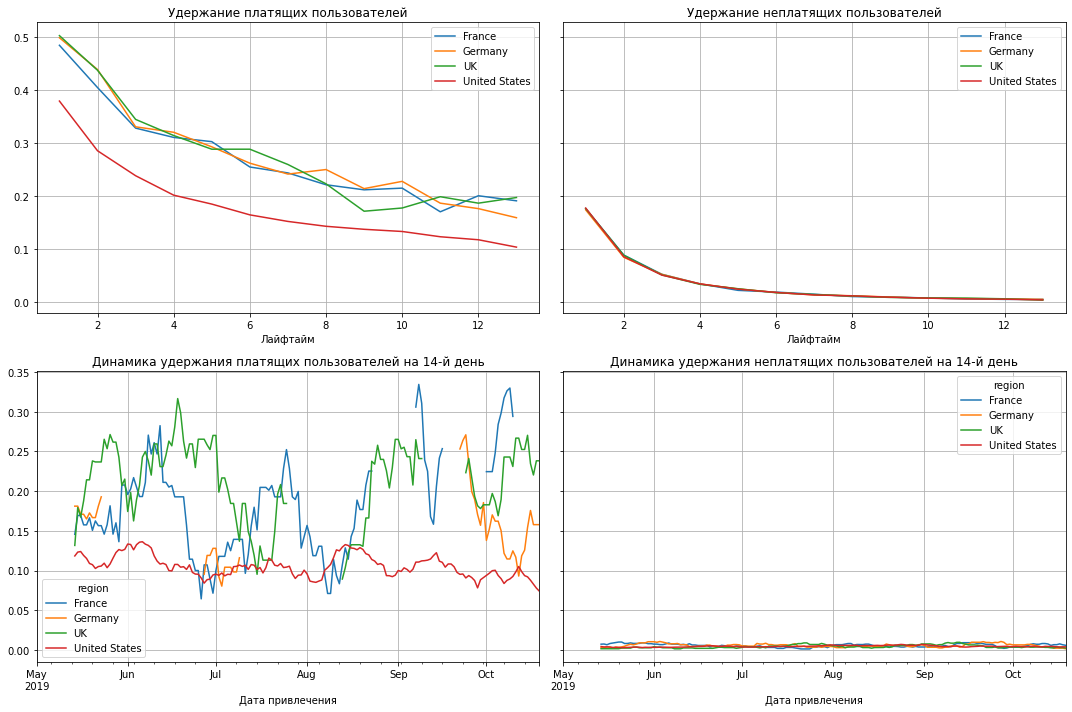

In [37]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region'])

plot_retention(retention_grouped, retention_history, horizon_days, window=14)

Посмотрим на конверсию и удержание с разбивкой по рекламным каналам

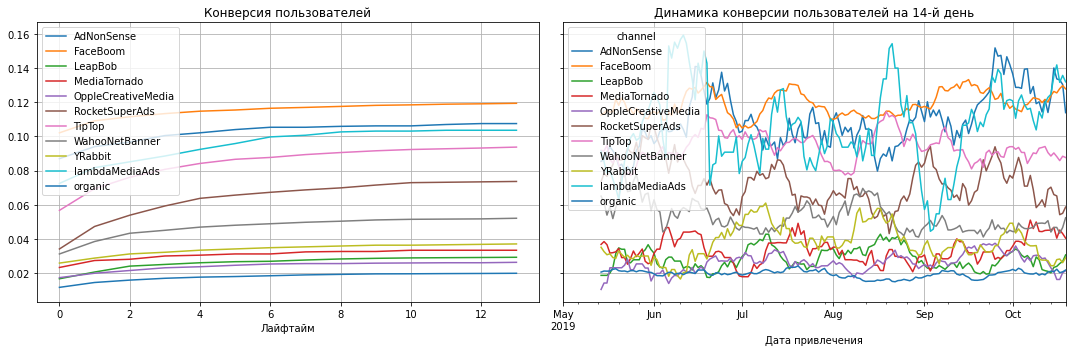

In [38]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

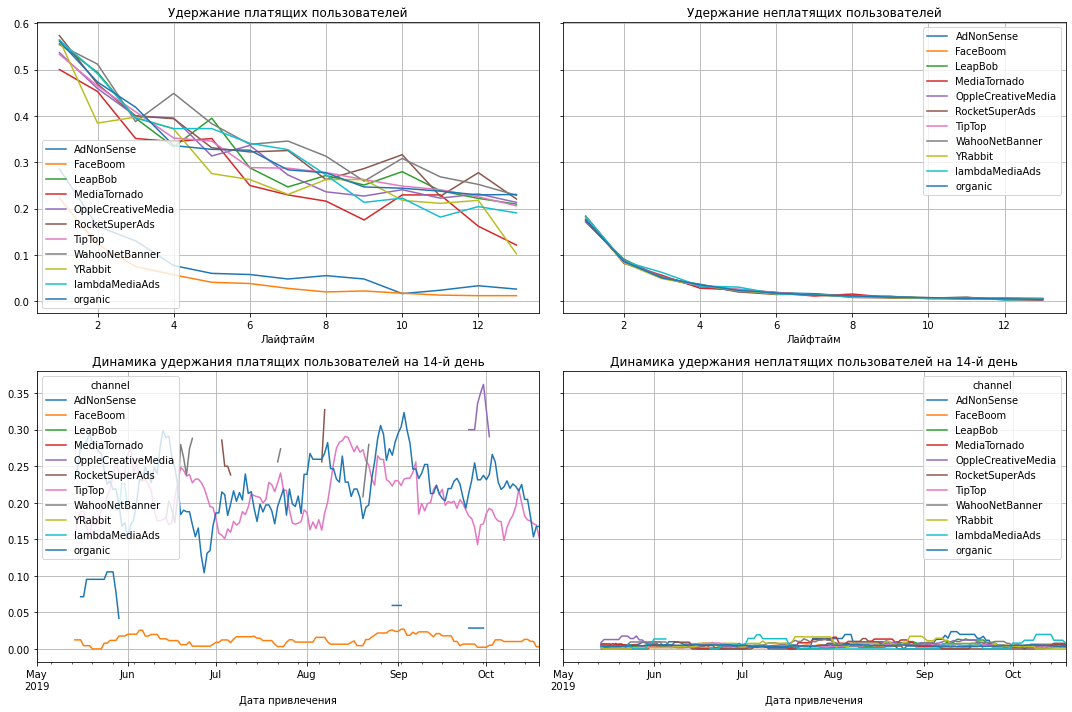

In [39]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel'])

plot_retention(retention_grouped, retention_history, horizon_days, window=14)

**Выводы:**

- Крайне низкий коэффициент удержания у рекламных каналов FaceBoom и AdNonSense
- Пользователи из американского региона показывают высокую конверсию, но низкий коэффициент удержания

## Общие выводы

**Причины неэффективности привлечения пользователей:**

- Привлечение пользователей через рекламные каналы TipTop, FaceBoom и AdNonSence оказалось убыточным. Особнно плохие результаты, в связи с ростом стоимости привлечения, показал TipTop.
- ROI пользователей из американского региона упал ниже уровня окупаемости в связи с ростом стоимости их привлечения

**Рекомендации для отдела маркетинга:**

- Остановить привлечение пользователей через убыточные рекламные каналы
- Найти более эффективные каналы привлечения для пользователей из американского региона